# Diabetes Prediction Model

## Data Analysis

### Making Imports

In [315]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from Functions.LinearRegression import FillerInterface
from Functions.GlucoseFill import GlucoseFiller
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, \
    classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

### Loading Dataset

In [316]:
df = pd.read_csv('Data/diabetes.csv')

### Handling Missing Data

In [317]:
df.shape

(768, 9)

In [318]:
df.head(100)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
95,6,144,72,27,228,33.9,0.255,40,0
96,2,92,62,28,0,31.6,0.130,24,0
97,1,71,48,18,76,20.4,0.323,22,0
98,6,93,50,30,64,28.7,0.356,23,0


<Axes: >

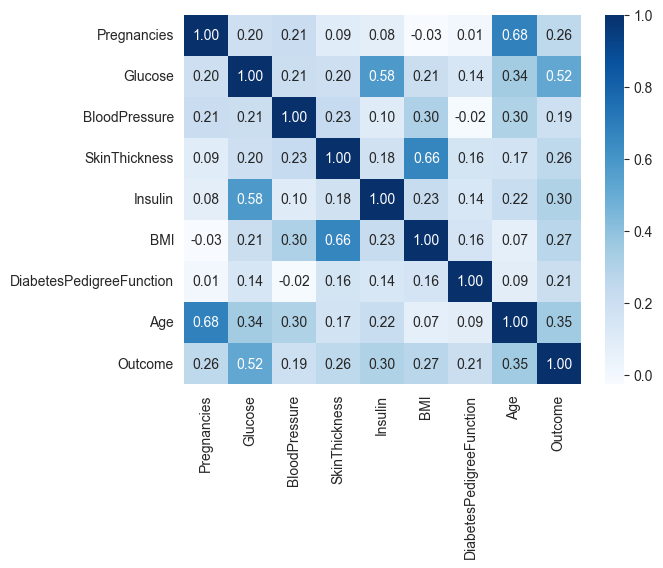

In [319]:
# True correlation without 0 values Before Filling
columns_to_check = ['BMI', 'Glucose', 'SkinThickness', 'BloodPressure', 'Insulin', 'DiabetesPedigreeFunction', 'Age']
filtered_df = df[(df[columns_to_check] != 0).all(axis=1)]
sns.heatmap(filtered_df.corr(), cmap='Blues', annot=True, fmt='.2f')

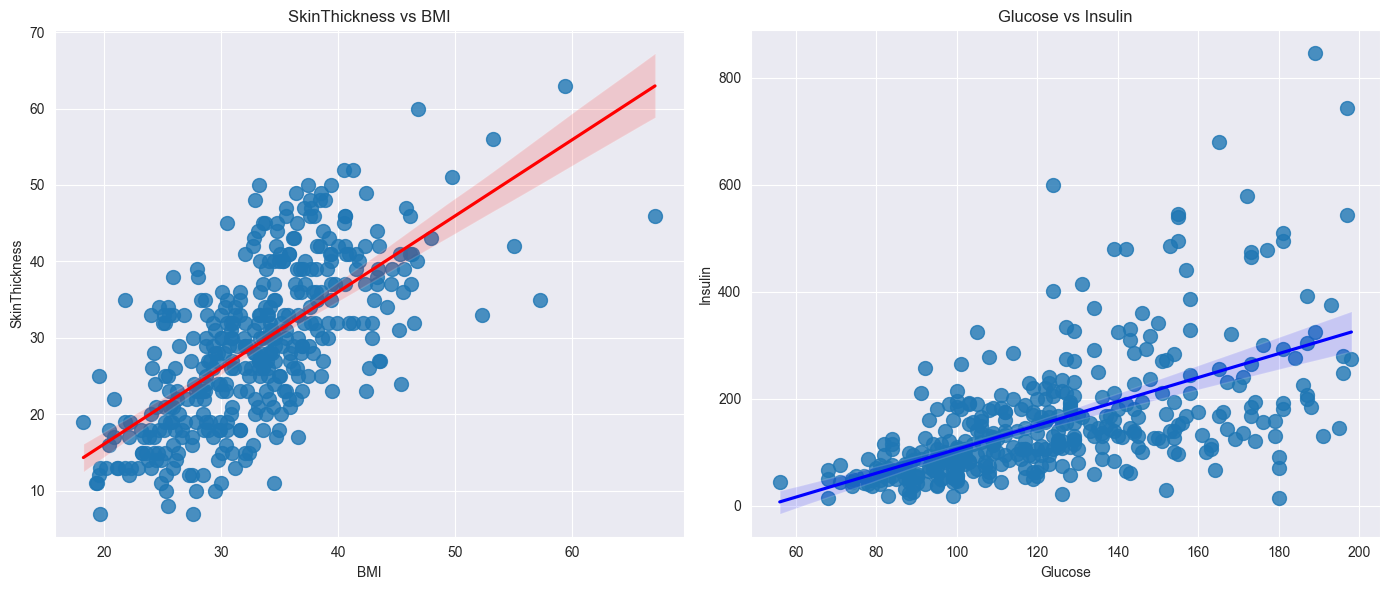

In [320]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.regplot(x='BMI', y='SkinThickness', data=filtered_df, ax=axes[0], scatter_kws={'s': 100}, line_kws={'color': 'red'})
axes[0].set_title('SkinThickness vs BMI')

sns.regplot(x='Glucose', y='Insulin', data=filtered_df, ax=axes[1], scatter_kws={'s': 100}, line_kws={'color': 'blue'})
axes[1].set_title('Glucose vs Insulin')
plt.tight_layout()
plt.show()

In [321]:
glucose_df = df[df['Glucose'] != 0]

In [322]:
summary_stats = glucose_df.groupby('Outcome')['Glucose'].agg([
    'mean',
    'median',
    'std',
    lambda x: x.mode()[0]  # Mode
])

# Rename the mode column
summary_stats.rename(columns={'<lambda_0>': 'mode'}, inplace=True)

print(summary_stats)

               mean  median        std  mode
Outcome                                     
0        110.643863   107.0  24.776906    99
1        142.319549   140.0  29.599199   125


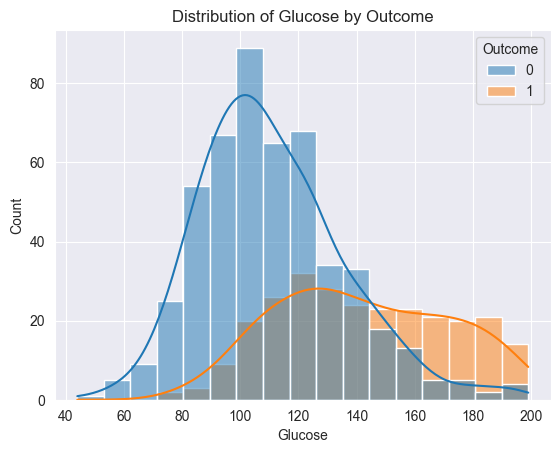

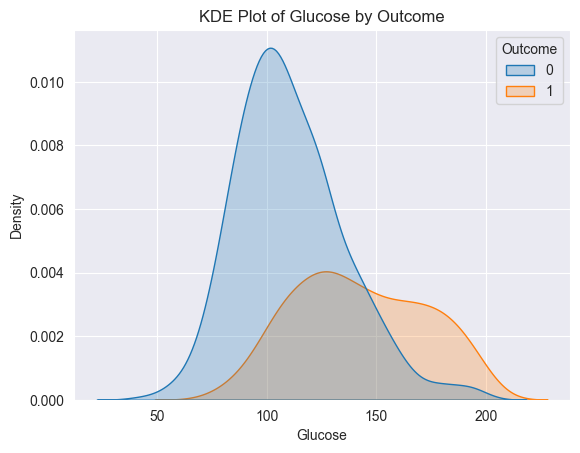

In [323]:
sns.histplot(data=glucose_df, x='Glucose', hue='Outcome', kde=True)
plt.title('Distribution of Glucose by Outcome')
plt.show()

# KDE plot
sns.kdeplot(data=glucose_df, x='Glucose', hue='Outcome', fill=True)
plt.title('KDE Plot of Glucose by Outcome')
plt.show()

In [324]:
glucose_filler = GlucoseFiller(df)
df = glucose_filler.get_dataframe

In [325]:
df['Glucose'].describe()

count    768.000000
mean     121.645833
std       30.483322
min       44.000000
25%       99.000000
50%      117.000000
75%      140.250000
max      199.000000
Name: Glucose, dtype: float64

In [326]:
Insulin_median_ill = df[(df.Insulin != 0) & (df.Outcome == 1)].Insulin.median()
Insulin_median_healthy = df[(df.Insulin != 0) & (df.Outcome == 0)].Insulin.median()


def fill_insulin(insulin_value, outcome):
    if pd.isna(insulin_value) or insulin_value == 0:
        return Insulin_median_ill if outcome == 1 else Insulin_median_healthy
    else:
        return insulin_value


df['Insulin'] = df.apply(lambda row: fill_insulin(row['Insulin'], row['Outcome']), axis=1)

<Axes: xlabel='Outcome', ylabel='Insulin'>

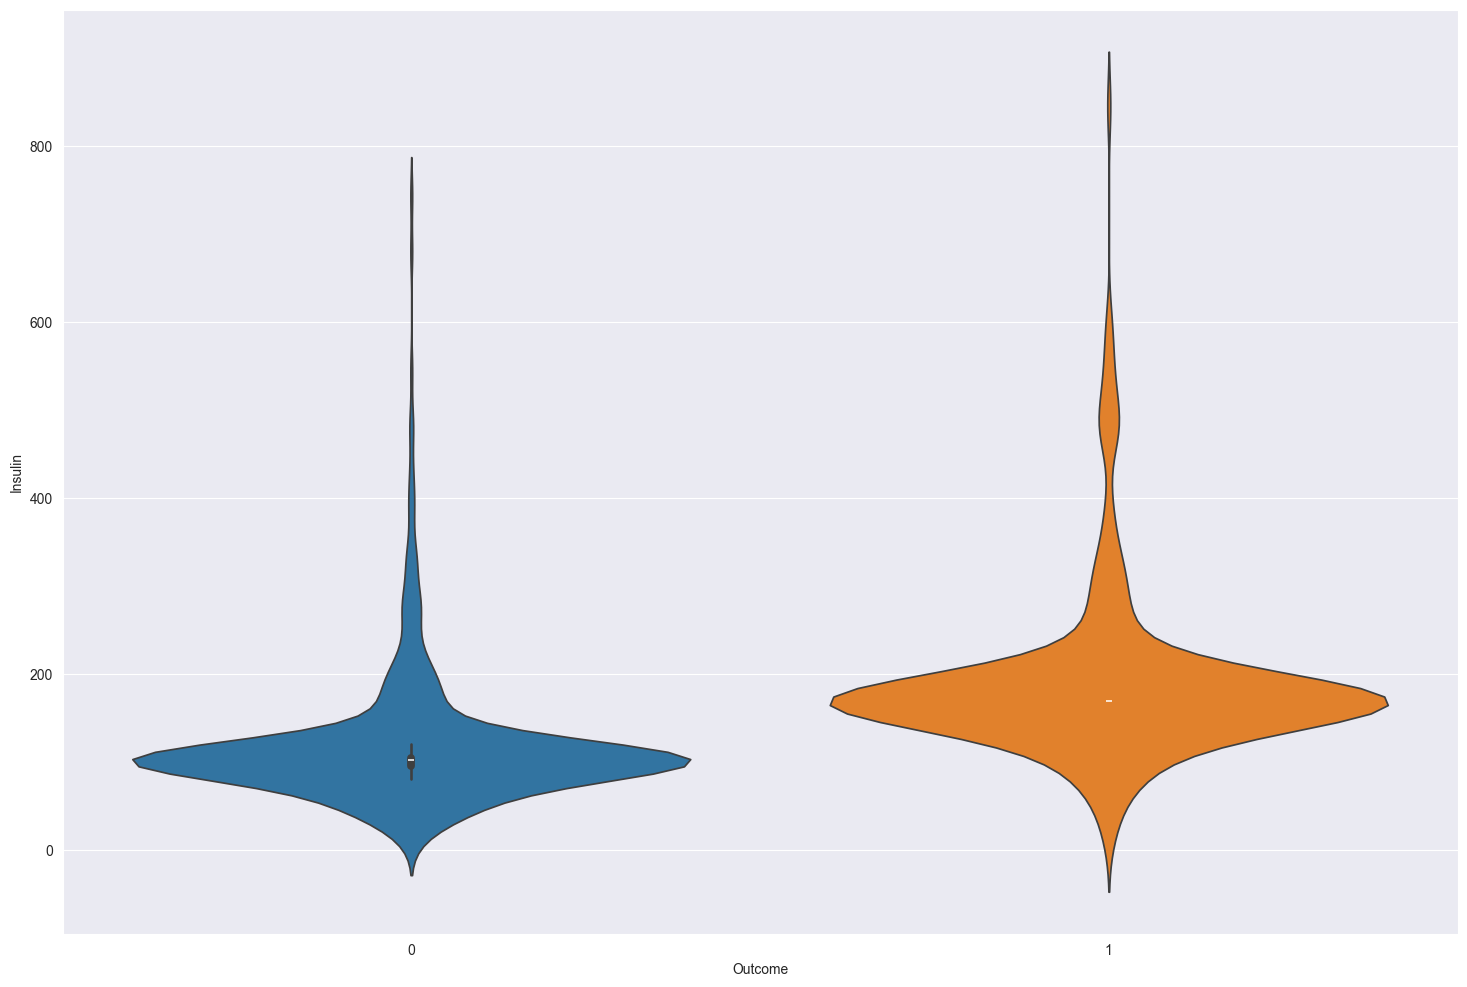

In [327]:
plt.figure(figsize=(18, 12))
sns.violinplot(df, x='Outcome', y='Insulin', hue='Outcome', legend=False)

In [328]:
df.Insulin.describe()

count    768.000000
mean     141.753906
std       89.100847
min       14.000000
25%      102.500000
50%      102.500000
75%      169.500000
max      846.000000
Name: Insulin, dtype: float64

df.loc[:, 'Insulin'] = df['Insulin'].apply(np.log)
df.Insulin.describe()

In [329]:
mean_blood_pressure = df[df['BloodPressure'] != 0]['BloodPressure'].mean()
df.loc[df['BloodPressure'] == 0, 'BloodPressure'] = mean_blood_pressure

/tmp/ipykernel_8277/2150545823.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '72.40518417462484' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['BloodPressure'] == 0, 'BloodPressure'] = mean_blood_pressure


In [330]:
df['Pregnancies_Binary'] = (df['Pregnancies'] >= 7).astype(int)
df = df.drop(columns='Pregnancies')

In [331]:
interface = FillerInterface(df)
interface.fill()
df = interface.get_dataframe

## Model Building

In [332]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, \
    classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.8355
Recall: 0.7021
Precision: 0.7500
F1 Score: 0.7253
ROC AUC: 0.8926

Confusion Matrix:
[[94 11]
 [14 33]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       105
           1       0.75      0.70      0.73        47

    accuracy                           0.84       152
   macro avg       0.81      0.80      0.80       152
weighted avg       0.83      0.84      0.83       152



In [333]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    "SVC": SVC(probability=True, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    if hasattr(model, 'predict_proba'):
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    else:
        roc_auc = roc_auc_score(y_test, model.decision_function(X_test))

    print(f"\n{name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))




Decision Tree:
Accuracy: 0.8596
Recall: 0.7838
Precision: 0.7838
F1 Score: 0.7838
ROC AUC: 0.8399

Confusion Matrix:
[[138  16]
 [ 16  58]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       154
           1       0.78      0.78      0.78        74

    accuracy                           0.86       228
   macro avg       0.84      0.84      0.84       228
weighted avg       0.86      0.86      0.86       228


Random Forest:
Accuracy: 0.8904
Recall: 0.8243
Precision: 0.8356
F1 Score: 0.8299
ROC AUC: 0.9449

Confusion Matrix:
[[142  12]
 [ 13  61]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       154
           1       0.84      0.82      0.83        74

    accuracy                           0.89       228
   macro avg       0.88      0.87      0.87       228
weighted avg       0.89      0.89      0.89       228


Neural Network:

In [334]:
# Best performed model - RandomForest

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=2)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; to

In [335]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, \
    classification_report

best_rf = RandomForestClassifier(
    bootstrap=False,
    max_depth=None,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=100,
    random_state=42
)

best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])

print("Random Forest with Best Parameters:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Random Forest with Best Parameters:
Accuracy: 0.8728
Recall: 0.8108
Precision: 0.8000
F1 Score: 0.8054
ROC AUC: 0.9456

Confusion Matrix:
[[139  15]
 [ 14  60]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       154
           1       0.80      0.81      0.81        74

    accuracy                           0.87       228
   macro avg       0.85      0.86      0.86       228
weighted avg       0.87      0.87      0.87       228



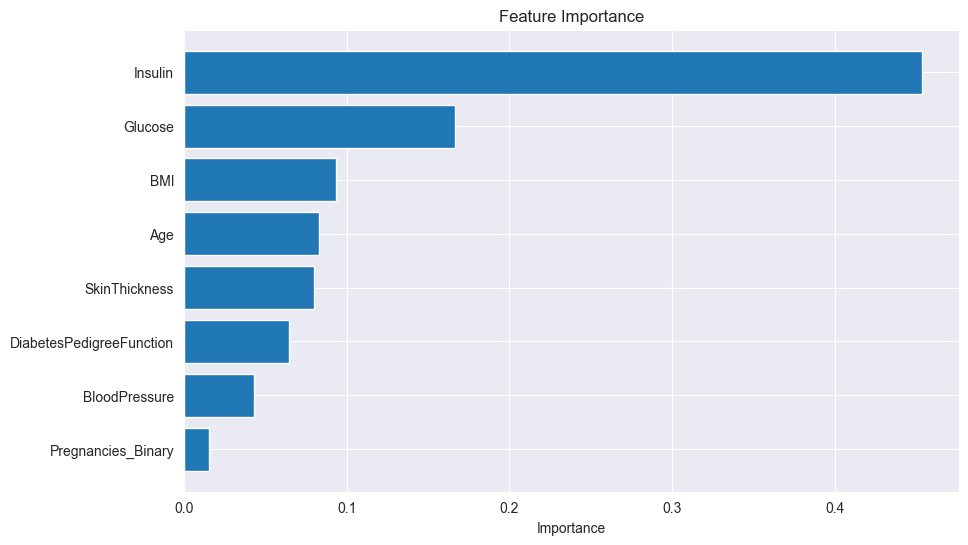

In [336]:
importances = best_rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()


In [337]:
import joblib

# Saving model
joblib.dump(best_rf, 'random_forest_model.pkl')

['random_forest_model.pkl']